<a href="https://colab.research.google.com/github/YusukeAoki57/diveintocode-ml/blob/master/Sprint_%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
import numpy as np

In [ ]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

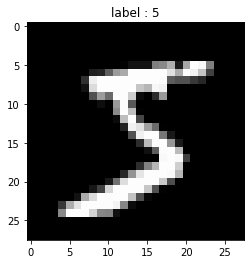

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

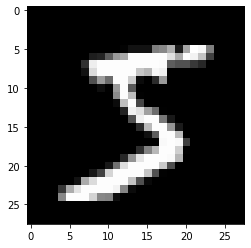

In [ ]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [ ]:
x_train = X_train.astype(np.float)
x_test = X_test.astype(np.float)
x_train /= 255
x_test /= 255
print(x_train.max())  # 1.0
print(x_train.min())  # 0.0

1.0
0.0


In [ ]:
def split_data(data, permutation, val_size_rate=0.2):
    data = data[permutation]
    val_size = int(len(data) * val_size_rate)
    val = data[:val_size]
    train = data[val_size:]
    return train, val

permutation = np.random.permutation(np.arange(len(x_train)))
x_train, x_val = split_data(x_train, permutation)
y_train, y_val = split_data(y_train, permutation)
print(x_train.shape)  # (48000, 784)
print(x_val.shape)  # (12000, 784)

(48000, 784)
(12000, 784)


In [ ]:
def get_minibatches(x, y, batch_size):
    """Returns a generator emits mini-batches.
    """
    size = x.shape[0]
    n_batches = size // batch_size
    shuffle_index = np.random.permutation(np.arange(size))
    new_size = batch_size * n_batches
    x_batches = np.split(x[shuffle_index][:new_size], n_batches)
    y_batches = np.split(y[shuffle_index][:new_size], n_batches)
    return zip(x_batches, y_batches)

In [ ]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, verbose = True,batch_size=20,a=0.01):
        self.verbose = verbose
        self.W1=None
        self.W2=None
        self.W3=None
        self.B1=None
        self.B2=None
        self.B3=None
        self.batch_size=batch_size
        self.Z1=None
        self.Z2=None
        self.Z3=None
        self.choice=0
        self.a=a
        pass
    def _forward(self,X):
        #第１層
        A1=np.dot(X,self.W1)+self.B1 #(20,784)*(784,400)=(20,400)
        if self.choice==1:
          self.Z1=1/(1+np.exp(-A1))
        else:
          self.Z1=np.tanh(A1)
        #第2層
        A2=np.dot(self.Z1,self.W2)+self.B2 #(20,400)*(400,200)=(20,200)

        if self.choice==1:
          self.Z2=1/(1+np.exp(-A2))
        else:
          self.Z2=np.tanh(A2)
        #第3層
        A3=np.dot(self.Z2,self.W3)+self.B3 #(20,200)*(200,10)=(20,10)
        log_z3 = np.log(np.exp(A3)) - self._logsumexp(A3) #(20,10)
        self.Z3 = np.exp(log_z3) #(20,10)
        return self.Z3
    
        #交差エントロピー関数
    def _forward_los(self,X,y):
        #self.y = self.y.reshape(-1, 1) == np.arange(10)
        self.Z3b=self._forward(X)
        #L = -(y * self.Z3b).mean(axis=0).sum()
        L=-np.sum(np.sum(y*np.log(self.Z3b),axis=1),axis=0)/self.batch_size #(20,10)*(20,10)→(1,10)→(1,1)
        return L
    def _backword(self,X,y):
        #3層目
        
        dA3=(self.Z3-y)/self.batch_size #(20,10)-(20,10)=(20,10)
        dB3=np.sum(dA3,axis=0) #(1,10)
        dW3=np.dot(self.Z2.T,dA3) #(200,20)*(20,10)=(200,10)
        dZ2=np.dot(dA3,self.W3.T) #(20,10)*(10,200)=(20,200)

        #2層目
        if self.choice==1:
          pass
        else:
          dA2=dZ2*(1-self.Z2**2) #(20,200)*(20,200)=(20,200)
        dB2=np.sum(dA2,axis=0) #(1,200)
        dW2=np.dot(self.Z1.T,dA2) #(400,20)*(20,200)=(400,200)
        dZ1=np.dot(dA2,self.W2.T) #(20,200)*(200,400)=(20,400)

        #1層目
        if self.choice==1:
          pass
        else:
          dA1=dZ1*(1-self.Z1**2) #(20,400)*(20,400)=(20,400)
        dB1=np.sum(dA1,axis=0) #(1,400)
        dW1=np.dot(X.T,dA1) #(784,20)*(20,400)=(784,400)

        #重みの更新
        self.W3=self.W3-self.a*dW3
        self.W2=self.W2-self.a*dW2
        self.W1=self.W1-self.a*dW1
        self.B3=self.B3-self.a*dB3
        self.B2=self.B2-self.a*dB2
        self.B1=self.B1-self.a*dB1
        
    def _logsumexp(self,A3):
        xmax = np.max(A3,axis=1)
        xmax=xmax.reshape(A3.shape[0],1)
        return np.log(np.exp(A3 - xmax).sum(axis=1, keepdims=True)) + xmax

    def fit(self, X, y, X_val, y_val):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        #問1:重みの初期値
        n_features = 784
        n_nodes1 = 400
        n_nodes2=200
        n_nodes3=10
        sigma = 0.01 # ガウス分布の標準偏差
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)# W1: (784, 400)
        self.W2 = sigma * np.random.randn(n_nodes1,n_nodes2)# W2: (400, 200)
        self.W3 = sigma * np.random.randn(n_nodes2,n_nodes3)# W2: (200, 10)

        #バイアス項の初期値
        self.B1=sigma * np.random.randn(n_nodes1,)
        self.B2=sigma * np.random.randn(n_nodes2,)
        self.B3=sigma * np.random.randn(n_nodes3,)
        self.X=X
        self.y=y
        n_epochs = 5
        n_step_iteration_report = 384
        plot_data = []
        Loss=[]
        Val_loss=[]
        Epoch=[]       
        y_val = y_val.reshape(-1, 1) == np.arange(10)
        for epoch in range(n_epochs):
            sum_of_loss = 0
            for i, (x, y) in enumerate(get_minibatches(self.X, self.y, self.batch_size)):
                y = y.reshape(-1, 1) == np.arange(10)
                y=y.reshape(y.shape[0],10)
                loss= self._forward_los(x, y)
                self._backword(x,y)
                sum_of_loss += loss
            Loss.append(loss)
            
       
            if self.verbose:
                for i, (x2, y2) in enumerate(get_minibatches(x_val, y_val, self.batch_size)):
                #train_loss = sum_of_loss / n_step_iteration_report
                  val_loss=self._forward_los(x2, y2)
                  print(val_loss)
                Val_loss.append(val_loss)
            Epoch.append(epoch)
                  #sum_of_loss = 0
                #iters_per_epoch = len(X) /self.batch_size
                #plot_data.append((epoch + (i + 1) / iters_per_epoch, train_loss, val_loss))
        if self.verbose:
          #epochs, train_loss, val_loss = zip(*plot_data)
          plt.plot(Epoch, Loss, color='r', label='train_loss')
          plt.plot(Epoch, Val_loss, color='b', label='val_loss')
          plt.xlabel('epoch')
          plt.ylabel('loss')
          plt.show()
      
        pass
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        return self._forward(X).argmax(axis=1)



0.8683047265026416
0.48248931518567606
0.528632011414379
0.7601820631965649
0.6237253902172065
0.47085074207797906
0.4190875666031569
0.49738785721817214
0.6305626017115714
0.5464065849767457
0.6821811243255643
0.6302007793436671
0.8130462436545806
1.1656750789605133
0.6108915462639289
0.5701307414629718
0.7133117306954695
0.6544147833487849
0.6252146041059781
0.5301013890742967
0.7389013422521076
0.5467424740228811
0.6494083138848269
0.3701617987937789
0.5208180711053948
0.3885006544070043
1.1607785697176816
0.7573576610745244
0.4769173300089801
0.41969231310860583
0.7492304925397149
0.5217907474592888
0.7382639516496854
0.6698192500297606
0.42935784020811046
0.4619545275438335
0.7434066834573383
0.7485845112326523
1.0200550903085064
0.5317336840216461
0.5538621199141825
0.6379449456176735
0.7251097818264932
0.9159259317341452
0.6938137288349382
0.5933496668280827
0.48513885914475396
0.41188203609679014
1.1886214356555778
0.5330248999670344
0.5393247994957733
0.7515214403911596
0.6075

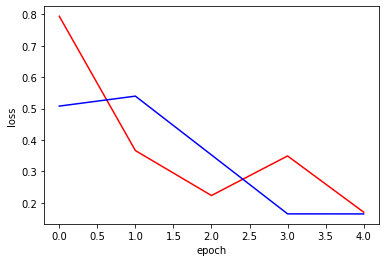

In [ ]:
NN=ScratchSimpleNeuralNetrowkClassifier()
NN.fit(x_train,y_train,x_val,y_val)

In [ ]:
y_pred=NN.predict(x_val)
print(y_pred)
print(y_pred.shape)

[7 6 0 ... 7 5 2]
(12000,)


In [ ]:
#Accuracy
from sklearn.metrics import accuracy_score
#スクラッチ
print(accuracy_score(y_val, y_pred))

0.9173333333333333
